In [1]:
#Bu problemde elimizdeki csv dosyasındaki bilgiler ile müşterilerin şirketi terk edip etmeyeceğini tahmin edeceğiz.Bakmamız gereken değer 'Churn' değeri.
# 1->Terk ediyor
# 0->Terk etmiyor

In [2]:
#Gerekli kütüphanelerin import edilmesi 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

In [3]:
pd.set_option('display.max_columns',None)
pd.set_option('display.width',170)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x: '%3f' %x)


In [4]:
df=pd.read_csv("Telco-Customer-Churn.csv")
df.head()
df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950000,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850000,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300000,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700000,151.65,Yes


In [5]:
#TotalCharges değeri görünürde sayısal lakin info bilgisini aldığımızda object gözüküyor bu yüzden TotalCharges değerlerini sayısala dönüştürelim
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce') #errors parametresi sütunda sayısal olmayan değeri NaN değere dönüştürür
#Churn değerlerini anlamlandırmak için 1 ve 0 olucak şekilde düzenleyelim
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950000,1889.500000,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850000,108.150000,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300000,1840.750000,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700000,151.650000,1


In [6]:
#Dataseti analizlemek için gerekli fonksiyonu yazalım
def check_df(data,head=7):
    print("--------SHAPE--------")
    print(data.shape)
    print("--------TYPES--------")
    print(data.dtypes)
    print("--------HEAD--------")
    print(data.head(head))
    print("--------TAIL--------")
    print(data.tail(head))
    print("--------NA DEGER--------")
    print(data.isnull().sum())
    print("--------QUANTILES--------")
    print(data.quantile([0,0.05,0.50,0.95,0.99,1]).T)

check_df(df)

    

--------SHAPE--------
(7043, 21)
--------TYPES--------
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object
--------HEAD--------
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes             

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [7]:
#Yukarıda aldığımız hatayı çözebilmek adına string ifadesi olan ve olmayan değerleri kontrol ediyoruz
df.applymap(lambda x: isinstance(x, str)).any()
#String içermeyen sütunlara göre quantile değerimizi tekrar görelim
print("--------QUANTILE--------")
print(df[["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges", "Churn"]].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


--------QUANTILE--------
                0.000000  0.050000    0.500000    0.950000    0.990000    1.000000
SeniorCitizen   0.000000  0.000000    0.000000    1.000000    1.000000    1.000000
tenure          0.000000  1.000000   29.000000   72.000000   72.000000   72.000000
MonthlyCharges 18.250000 19.650000   70.350000  107.400000  114.729000  118.750000
TotalCharges   18.800000 49.605000 1397.475000 6923.590000 8039.883000 8684.800000
Churn           0.000000  0.000000    0.000000    1.000000    1.000000    1.000000


In [8]:
#Numerik-Kategorik Değişkenlerin Yakalanması
#(cat_th->int,optional(numerik fakat kategorik değişlenler eşik değeri)
#car_th->intüoptional(kategorik fakat kardinal değişkenler için eşik değeri)
def grabbing_columns(data,cat_th=10,car_th=10): 
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"]
    num_but_cat = [col for col in data.columns if data[col].nunique() < cat_th and data[col].dtypes != "O"]
    cat_but_car = [col for col in data.columns if data[col].nunique() > car_th and data[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in data.columns if data[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {data.shape[0]}")
    print(f"Variables: {data.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grabbing_columns(df)
print("--------Cat Cols--------")
print(cat_cols)
print("--------Num Cols--------")
print(num_cols)
print("--------Cat but Car--------")
print(cat_but_car)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2
--------Cat Cols--------
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn']
--------Num Cols--------
['tenure', 'MonthlyCharges', 'TotalCharges']
--------Cat but Car--------
['customerID']


In [ ]:
#Kategorik Değişkenlerin Analizi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

count   7043.000000
mean      32.371149
std       24.559481
min        0.000000
5%         1.000000
10%        2.000000
20%        6.000000
30%       12.000000
40%       20.000000
50%       29.000000
60%       40.000000
70%       50.000000
80%       60.000000
90%       69.000000
95%       72.000000
99%       72.000000
max       72.000000
Name: tenure, dtype: float64


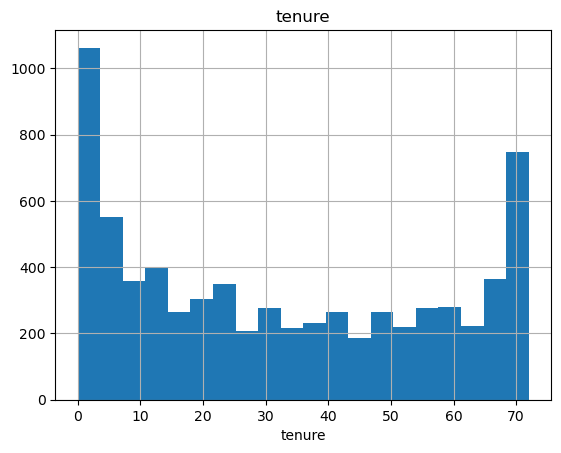

count   7043.000000
mean      64.761692
std       30.090047
min       18.250000
5%        19.650000
10%       20.050000
20%       25.050000
30%       45.850000
40%       58.830000
50%       70.350000
60%       79.100000
70%       85.500000
80%       94.250000
90%      102.600000
95%      107.400000
99%      114.729000
max      118.750000
Name: MonthlyCharges, dtype: float64


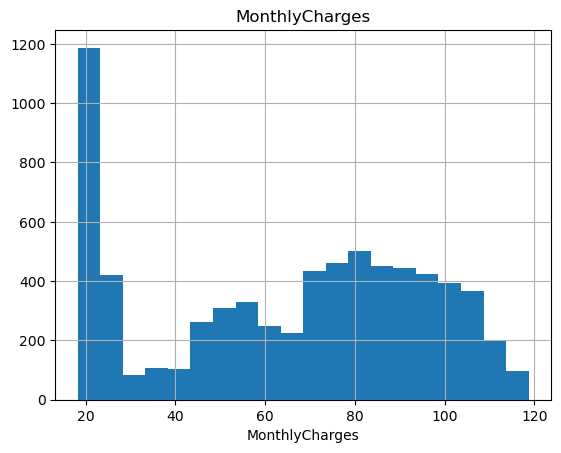

count   7032.000000
mean    2283.300441
std     2266.771362
min       18.800000
5%        49.605000
10%       84.600000
20%      267.070000
30%      551.995000
40%      944.170000
50%     1397.475000
60%     2048.950000
70%     3141.130000
80%     4475.410000
90%     5976.640000
95%     6923.590000
99%     8039.883000
max     8684.800000
Name: TotalCharges, dtype: float64


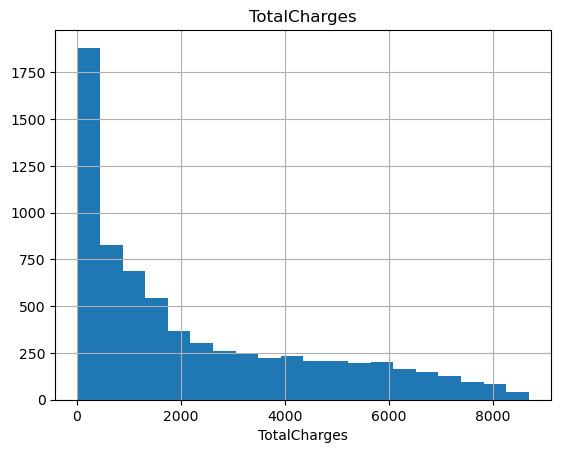

In [9]:
#Numerik Değişkenlerin Analizi
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

In [10]:
#Numerik Değişkenlerin Targete Göre Analizi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Churn", col)

         tenure
Churn          
0     37.569965
1     17.979133


       MonthlyCharges
Churn                
0           61.265124
1           74.441332


       TotalCharges
Churn              
0       2555.344141
1       1531.796094




In [11]:
#Kategorik Değişkenlerin Targere Göre Analizi
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count     Ratio
gender                              
Female     0.269209   3488 49.524350
Male       0.261603   3555 50.475650


Partner
         TARGET_MEAN  Count     Ratio
Partner                              
No          0.329580   3641 51.696720
Yes         0.196649   3402 48.303280


Dependents
            TARGET_MEAN  Count     Ratio
Dependents                              
No             0.312791   4933 70.041176
Yes            0.154502   2110 29.958824


PhoneService
              TARGET_MEAN  Count     Ratio
PhoneService                              
No               0.249267    682  9.683374
Yes              0.267096   6361 90.316626


MultipleLines
                  TARGET_MEAN  Count     Ratio
MultipleLines                                 
No                   0.250442   3390 48.132898
No phone service     0.249267    682  9.683374
Yes                  0.286099   2971 42.183729


InternetService
                 TARGET_MEAN  Count     Ratio
Inte

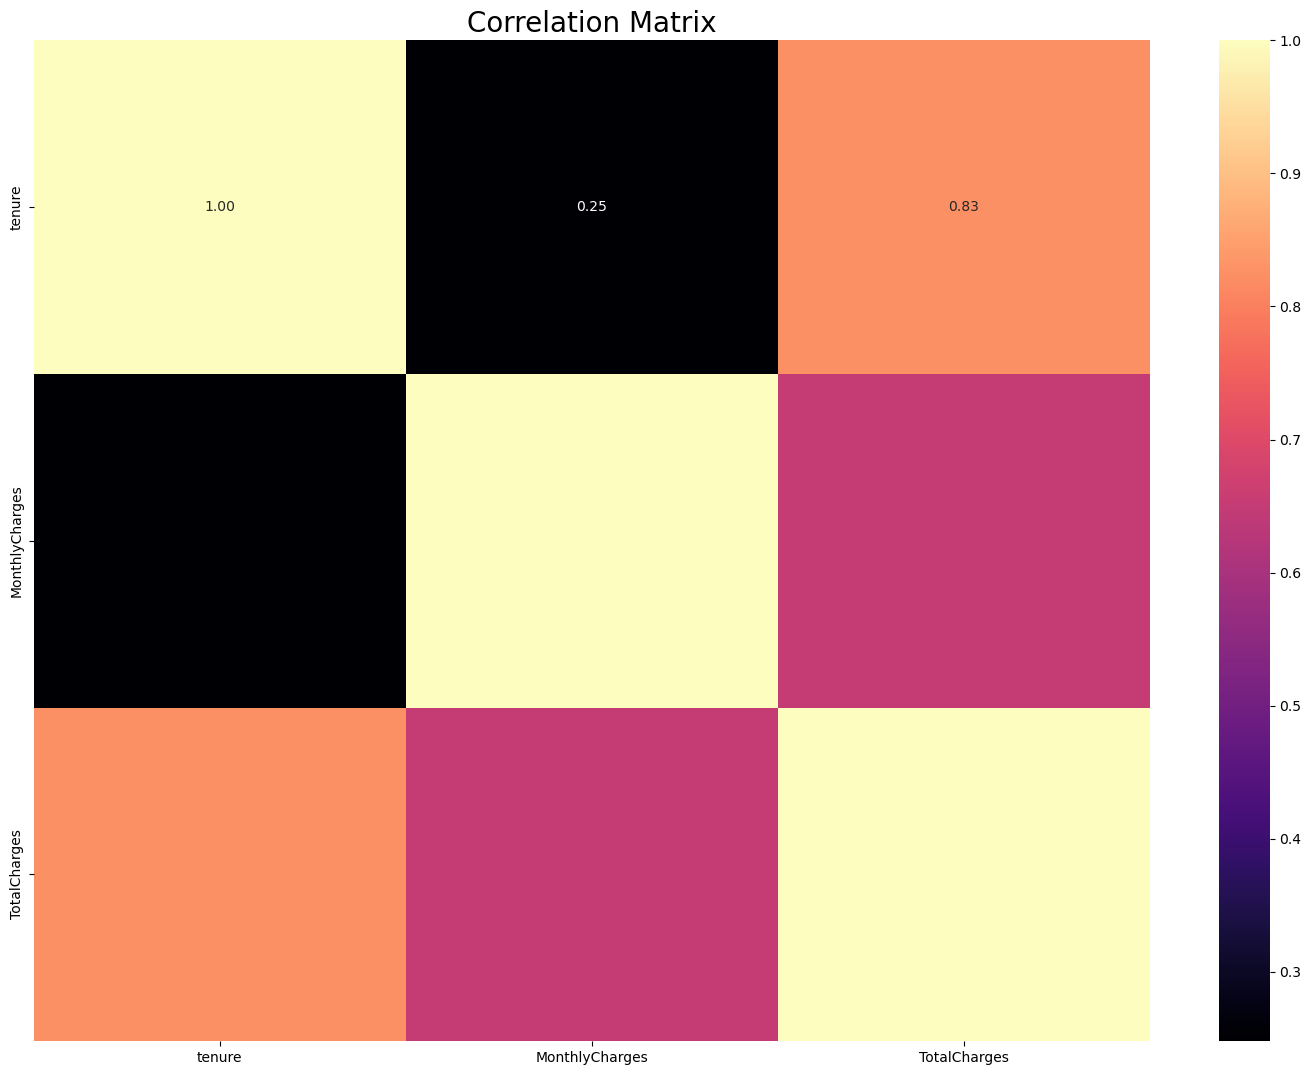

In [12]:
#Korelasyon
df[num_cols].corr()
#Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

#Tenure ve TotalCharge arasında yüksek korelasyon olduğu gözleniyor.

In [13]:
#Eksik Değer Analizi
#Veri Setinde ki eksik değer sayıları
df.isnull().sum()

def missing_values(data,na_name=False):
    na_columns=[col for col in data.columns if data[col].isnull().sum()>0]
    n_miss=data[na_columns].isnull().sum().sort_values(ascending=False)
    ratio=(data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values(df, na_name=True)

df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
df.isnull().sum()

              n_miss    ratio
TotalCharges      11 0.160000


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [14]:
#Base Modeli OLuşturmak
df.head()
dff=df.copy()
cat_cols= [col for col in cat_cols if col not in ["Churn"]]

def one_hot_encoder(data,categorical_col,drop_first=False):
    data=pd.get_dummies(data,columns=categorical_col,drop_first=drop_first, dtype=int)
    return data 
dff=one_hot_encoder(dff,cat_cols,drop_first=True)

In [15]:
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1
0,7590-VHVEG,1,29.850000,29.850000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,34,56.950000,1889.500000,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,2,53.850000,108.150000,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,7795-CFOCW,45,42.300000,1840.750000,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,2,70.700000,151.650000,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [16]:
y=dff["Churn"]
X=dff.drop(["Churn","customerID"],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=17)
catboost_model=CatBoostClassifier(verbose=False,random_state=42).fit(X_train,y_train)
y_pred=catboost_model.predict(X_test)

In [17]:
print(X_test)
print(X_train)

      tenure  MonthlyCharges  TotalCharges  gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  MultipleLines_No phone service  MultipleLines_Yes  \
3616      69       87.300000   6055.550000            0            1               0                 1                               0                  0   
2055      45      108.450000   4964.700000            1            0               0                 1                               0                  1   
5394      48      105.100000   5083.550000            0            1               0                 1                               0                  1   
3697      32       89.600000   2901.800000            0            1               1                 1                               0                  1   
2516      16       96.400000   1581.200000            0            0               0                 1                               0                  1   
6368       2       94.000000    181.700000            1   

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [18]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred,y_test),4)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 4)}")
print(f"F1: {round(f1_score(y_pred,y_test), 4)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 4)}")

Accuracy: 0.7889
Recall: 0.6448
Precision: 0.4965
F1: 0.561
Auc: 0.7359


In [19]:
#Aykırı Değerleri Analiz Etmek 


#Üst ve alt sınırları belirlemek
def outlier_thresholds(data,col_name,q1=0.05,q3=0.95):
    quartile1=data[col_name].quantile(q1)
    quartile3=data[col_name].quantile(q3)
    interquartile_range=quartile3-quartile1
    up_limit=quartile3+1.5*interquartile_range
    low_limit=quartile1-1.5-interquartile_range
    return up_limit,low_limit

#Aykırı değerleri tespit etmek
def check_outlier(data,col_name):
    low_limit,up_limit=outlier_thresholds(data,col_name)
    if data[(data[col_name] > up_limit) | (data[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False 


#Alt ve üst sınırları değerlerle değiştirmek
def replace_with_thresholds(data, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(data, variable, q1=0.05, q3=0.95)
    data.loc[(data[variable] < low_limit), variable] = low_limit
    data.loc[(data[variable] > up_limit), variable] = up_limit


#Baskılama İşlemi
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)


tenure True
MonthlyCharges True
TotalCharges True


In [20]:
#Özellik Oluşturma
#Tenure Değişkeninden yıllık kategorik değişken oluşturmak 
df.loc[(df["tenure"]>=0) &(df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) &(df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) &(df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) &(df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) &(df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) &(df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [21]:
#Kontratı 1-2 yıllık müşterileri Engaged olarak belirtmek 
df["NEW_Engaged"] =df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

#Hiç destek,yedek veya koruma almayan kişiler
df["NEW_noProt"]=df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

#Aylık sözleşmesi bulunan ve genç olan müşteriler
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

#Toplam alınan hizmet sayısı 
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

#Herhangi streaming hizmeti alanlar
df["NEW_ANY_STREAMING"]=df.apply(lambda x:1 if (x["StreamingTV"]=="Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

#Ortalama aylık ödeme 
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

#Güncel Fiyatın ortalama fiyata göre artışı
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

#Servis başına ücret
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [22]:
df.head()
df.shape

(7043, 30)

In [24]:
# ENCODING İŞlEMİ
#Değişkenlerin tiplerine göre ayrılması 
cat_cols,num_cols,cat_but_car=grabbing_columns(df)

#Label Encoding
def label_encoder(data,binary_col):
    labelencoder=LabelEncoder()
    data[binary_col]=labelencoder.fit_transform(data[binary_col])
    return data 

binary_cols=[col for col in df.columns if df[col].dtypes=="O" and df[col].nunique()==2]
print(binary_cols)

for col in binary_cols:
    df=label_encoder(df,col)

#One-Hot Encoding İşlemi 
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first,dtype=int)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

Observations: 7043
Variables: 41
cat_cols: 40
num_cols: 0
cat_but_car: 1
num_but_cat: 40
[]


,customerID,Churn,NEW_TotalServices,gender_1,Partner_1,Dependents_1,PhoneService_1,PaperlessBilling_1,MultipleLines_No phone service_True,MultipleLines_Yes_True,InternetService_Fiber optic_True,InternetService_No_True,OnlineSecurity_No internet service_True,OnlineSecurity_Yes_True,OnlineBackup_No internet service_True,OnlineBackup_Yes_True,DeviceProtection_No internet service_True,DeviceProtection_Yes_True,TechSupport_No internet service_True,TechSupport_Yes_True,StreamingTV_No internet service_True,StreamingTV_Yes_True,StreamingMovies_No internet service_True,StreamingMovies_Yes_True,Contract_One year_True,Contract_Two year_True,PaymentMethod_Credit card (automatic)_True,PaymentMethod_Electronic check_True,PaymentMethod_Mailed check_True,SeniorCitizen_1_True,NEW_Engaged_1_True,NEW_noProt_1_True,NEW_Young_Not_Engaged_1_True,NEW_ANY_STREAMING_1_True,NEW_AVG_Service_Fee_-34.8_True,NEW_AVG_Service_Fee_-23.2_True,NEW_AVG_Service_Fee_-17.4_True,NEW_AVG_Service_Fee_-13.919999999999998_True,NEW_AVG_Service_Fee_-11.6_True,NEW_AVG_Service_Fee_-9.942857142857141_True,NEW_AVG_Service_Fee_-8.7_True
0,7590-VHVEG,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0
1,5575-GNVDE,0,3,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0
2,3668-QPYBK,1,3,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0
3,7795-CFOCW,0,3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
4,9237-HQITU,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0


In [25]:
#Son yapılan işlemlerden sonra tekrar modelleme işlemi 
y=df["Churn"]
X=df.drop(["Churn","customerID"], axis=1)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.30, random_state=17)
catboost_model=CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred=catboost_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.76
Recall: 0.57
Precision: 0.46
F1: 0.51
Auc: 0.69
